# Data Exploration

Dataset used in this project is small "Sparkify" dataset containing different users interactions with the music streaming service (like Spotify or Pandora). Interactions could be playing the song, loginig out, giving the thumbs up etc. 

In this project due to technical limitations I'm going to work on a tiny subset (128MB) of the full dataset available (12GB).

My objective is to create a machine learning model for churn prediction, but before I do that I need to get familiar with the dataset.

In [1]:
# import libraries
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import datetime
import pandas as pd

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify_Project") \
    .getOrCreate()

In [3]:
# loading dataset
path = "mini_sparkify_event_data.json"
data = spark.read.json(path)

In [4]:
# Let's look at the schema first
data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
# Let's look at some example records
data.filter(data.userId == "10").select("userId", "page", "ts", "song", "artist", "level").orderBy("ts").show(5, False)

+------+--------+-------------+---------------------------------------------------+----------------------+-----+
|userId|page    |ts           |song                                               |artist                |level|
+------+--------+-------------+---------------------------------------------------+----------------------+-----+
|10    |NextSong|1538965220000|Ses Monuments                                      |Sea Wolf              |paid |
|10    |NextSong|1538965485000|Morning Sky                                        |George Baker Selection|paid |
|10    |NextSong|1538965685000|Du Hast'n Freund In Mir (You've Got A Friend In Me)|Klaus Lage            |paid |
|10    |NextSong|1538965893000|Playera                                            |Dave Grusin           |paid |
|10    |NextSong|1538966419000|Burnin' For You                                    |Blue Oyster Cult      |paid |
+------+--------+-------------+---------------------------------------------------+-------------

In [6]:
# What is number of records in this dataset:
data.count()

286500

In [7]:
# What is the number of unique users:
data.select("userId").dropDuplicates().count()

226

In [9]:
# Let's see what interactions are included in the dataset, this information is kept in "page" column
df_hist = data.groupBy("page").count().orderBy(F.desc("count"))

In [10]:
df_hist.show()

+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|228108|
|                Home| 14457|
|           Thumbs Up| 12551|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|         Roll Advert|  3933|
|               Login|  3241|
|              Logout|  3226|
|         Thumbs Down|  2546|
|           Downgrade|  2055|
|                Help|  1726|
|            Settings|  1514|
|               About|   924|
|             Upgrade|   499|
|       Save Settings|   310|
|               Error|   258|
|      Submit Upgrade|   159|
|    Submit Downgrade|    63|
|              Cancel|    52|
|Cancellation Conf...|    52|
+--------------------+------+
only showing top 20 rows



In [13]:
df_hist_pd = df_hist.toPandas()

<AxesSubplot:xlabel='Type of user interaction with service', ylabel='Number of interactions'>

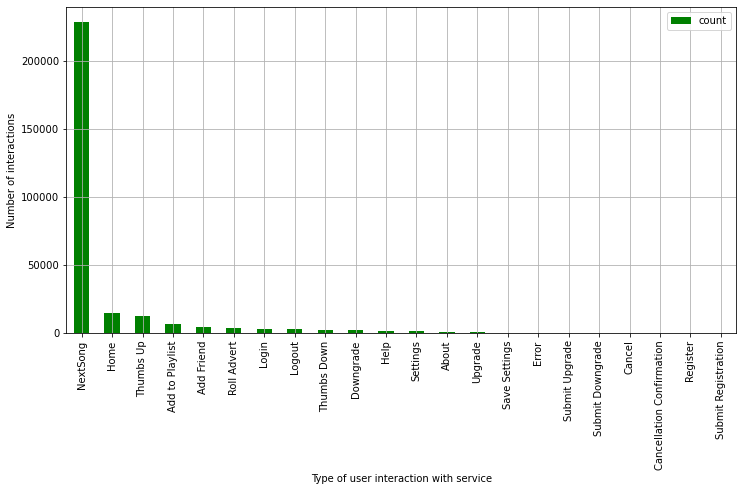

In [27]:
df_hist_pd.plot.bar(x='page',y='count', color = 'g', figsize=(12,6), grid=True, xlabel='Type of user interaction with service', ylabel='Number of interactions')

In [9]:
# Let's take closer look into userId and sessionId columns:
data.describe("userId", "sessionId", "page", "ts").show()

+-------+------------------+-----------------+-------+--------------------+
|summary|            userId|        sessionId|   page|                  ts|
+-------+------------------+-----------------+-------+--------------------+
|  count|            286500|           286500| 286500|              286500|
|   mean| 59682.02278593872|1041.526554973822|   NULL|1.540956889810471...|
| stddev|109091.94999910535|726.7762634630799|   NULL| 1.507543960819624E9|
|    min|                  |                1|  About|       1538352117000|
|    max|                99|             2474|Upgrade|       1543799476000|
+-------+------------------+-----------------+-------+--------------------+



In [10]:
# It seems there are some ampty values for userId

In [11]:
# Let's also take a look on ts column:
data.select("userId", "ts").orderBy("userId", "ts").show(20, False)

+------+-------------+
|userId|ts           |
+------+-------------+
|      |1538355745000|
|      |1538355807000|
|      |1538355841000|
|      |1538355842000|
|      |1538356678000|
|      |1538356679000|
|      |1538358102000|
|      |1538360117000|
|      |1538361527000|
|      |1538361528000|
|      |1538362007000|
|      |1538362095000|
|      |1538362096000|
|      |1538363488000|
|      |1538363494000|
|      |1538363503000|
|      |1538364254000|
|      |1538364255000|
|      |1538364750000|
|      |1538370681000|
+------+-------------+
only showing top 20 rows



In [33]:
data.count()

286500

In [39]:
#from pyspark.sql.functions import col,isnan,when,count
data_empty = data.select([F.count(F.when(F.col(c).contains('None') | \
                            F.col(c).contains('NULL') | \
                            (F.col(c) == '' ) | \
                            F.col(c).isNull() | \
                            F.isnan(c), c 
                           )).alias(c)
                    for c in data.columns])
data_empty.show(vertical=True)

-RECORD 0--------------
 artist        | 58406 
 auth          | 0     
 firstName     | 8346  
 gender        | 8346  
 itemInSession | 0     
 lastName      | 8346  
 length        | 58392 
 level         | 0     
 location      | 8346  
 method        | 0     
 page          | 0     
 registration  | 8346  
 sessionId     | 0     
 song          | 58445 
 status        | 0     
 ts            | 0     
 userAgent     | 8346  
 userId        | 8346  



# Data Cleaning

In this step I'm gonna get rid of empty values for userId and sessionId and change format of "ts" column

In [12]:
data_valid = (
    data.
    dropna(how = "any", subset = ["userId", "sessionId"]).
    filter(data["userId"] != "").
    withColumn("ts", F.from_unixtime(data.ts / 1000.0, "yyyy-MM-dd HH:mm:ss"))
)

In [13]:
# Let's check for empty values again:
data_valid.describe("userId", "sessionId").show()

+-------+------------------+------------------+
|summary|            userId|         sessionId|
+-------+------------------+------------------+
|  count|            278154|            278154|
|   mean| 59682.02278593872|1042.5616241362698|
| stddev|109091.94999910535| 726.5010362219824|
|    min|                10|                 1|
|    max|                99|              2474|
+-------+------------------+------------------+



In [14]:
# Let's check number of users again
data_valid.select("userId").dropDuplicates().count()

225

In [15]:
# We have one user less

In [16]:
#Let's look at timestamp column:
data_valid.select("ts").show(20, False)

+-------------------+
|ts                 |
+-------------------+
|2018-10-01 02:01:57|
|2018-10-01 02:03:00|
|2018-10-01 02:06:34|
|2018-10-01 02:06:56|
|2018-10-01 02:11:16|
|2018-10-01 02:11:18|
|2018-10-01 02:14:46|
|2018-10-01 02:14:59|
|2018-10-01 02:15:05|
|2018-10-01 02:18:04|
|2018-10-01 02:19:06|
|2018-10-01 02:19:10|
|2018-10-01 02:20:18|
|2018-10-01 02:22:55|
|2018-10-01 02:22:56|
|2018-10-01 02:24:01|
|2018-10-01 02:26:16|
|2018-10-01 02:27:48|
|2018-10-01 02:28:07|
|2018-10-01 02:29:04|
+-------------------+
only showing top 20 rows



In [17]:
# It looks much better

In [20]:
# Let's save our cleaned dataset
path_save = "mini_sparkify_event_data_cleaned.json"
data_valid.coalesce(1).write.mode("overwrite").format('json').save(path_save)